# K-Means

### Será analisada uma base de dados contendo a localização de fontes de água potável na cidade de Vancouver para identficação de regiões. 

### Base de dados pode ser obtida no portal de dados da cidade de Vancouver: [City of Vancouver Open Data Portal](https://opendata.vancouver.ca/explore/embed/dataset/drinking-fountains/table/?disjunctive.geo_local_area)

In [11]:
import pandas as pd
data = pd.read_csv('drinkingFountains.csv', names = ['latitude', 'longitude'])
data

,latitude,longitude
0,49.234947,-123.027254
1,49.275858,-123.024141
2,49.285554,-123.142392
3,49.260980,-123.184759
4,49.278811,-123.106194
...,...,...
235,49.205331,-123.031131
236,49.213173,-123.114629
237,49.279672,-123.123513
238,49.271674,-123.167863


### Bibliotecas a serem utilizadas

In [5]:
import random as rand
import math as math
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import csv
from point import Point

### Algoritmo K-Means 

In [6]:
class clustering:
    def __init__(self, geo_loc, k):
        self.geo_locations = geo_loc
        self.k = k
        self.clusters = [] #Clusters
        self.means = [] #Cluster's means
        self.debug = False #Debug flag

    # Função para a escolha dos 7 outros centróides após aletóriamente escolher o primeiro
    def next_random(self, index, points, clusters):
        dist = {}
        for point_1 in points:
            if self.debug:
                print('point 1: %f%f' %(point_1.latit, point_1.longit))
            for cluster in clusters.values():
                point_2 = cluster[0]
                if self.debug:
                    print('point 2: %f%f' %(point_2.latit, point_2.longit))
                if point_1 not in dist:
                    dist[point_1] = math.sqrt(math.pow(point_1.latit - point_2.latit, 2.0) + math.pow(point_1.longit - point_2.longit, 2.0))
                else:
                    dist[point_1] += math.sqrt(math.pow(point_1.latit - point_2.latit, 2.0) + math.pow(point_1.longit - point_2.longit, 2.0))
        if self.debug:
            for key, value in dist.items():
                print('(%f%f) ==> %f' %(key.latit, key.longit, value))
        count_ = 0
        max_ = 0
        for key, value in dist.items():
            if count_ == 0:
                max_ = value
                max_point = key
                count_ += 1
            else:
                if value > max_:
                    max_ = value
                    max_point = key
        return max_point

    # Função para escolha de um centróide aletório
    def initial_means(self, points):
        point_ = rand.choice(points)
        if self.debug:
            print('point#0: %f %f' %(point_.latit, point_.longit))
        clusters = dict()
        clusters.setdefault(0, []).append(point_)
        points.remove(point_)
        for i in  range(1, self.k):
            point_ = self.next_random(i, points, clusters)
            if self.debug:
                print('point#%d: %f %f' % (i, point_.latit, point_.longit))
            clusters.setdefault(i, []).append(point_)
            points.remove(point_)
        self.means = self.compute_mean(clusters)
        if self.debug:
            print("initial means:")
            self.print_means(self.means)

    # Função para definição dos centróides
    def compute_mean(self, clusters):
        means = []
        for cluster in clusters.values():
            mean_point = Point(0.0, 0.0)
            cnt = 0.0
            for point in cluster:
                mean_point.latit += point.latit
                mean_point.longit += point.longit
                cnt += 1.0
            mean_point.latit = mean_point.latit/cnt
            mean_point.longit = mean_point.longit/cnt
            means.append(mean_point)
        return means

    # Função para alocação dos pontos para os centróides mais próximos
    def assign_points(self, points):
        if self.debug:
            print('assign points')
        clusters = dict()
        for point in points:
            dist = []
            if self.debug:
                print("point(%f,%f)" % (point.latit, point.longit))
            for mean in self.means:
                dist.append(math.sqrt(math.pow(point.latit - mean.latit,2.0) + math.pow(point.longit - mean.longit,2.0)))
            if self.debug:
                print (dist)
            cnt_ = 0
            index = 0
            min_ = dist[0]
            for d in dist:
                if d < min_:
                    min_ = d
                    index = cnt_
                cnt_ += 1
            if self.debug:
                print ("index: %d" % index)
            clusters.setdefault(index, []).append(point)
        return clusters

    # Função para checar convergência dos centróides
    def update_means(self, means, threshold):
        for i in range(len(self.means)):
            mean_1 = self.means[i]
            mean_2 = means[i]
            if self.debug:
                print ("mean_1(%f,%f)" % (mean_1.latit, mean_1.longit))
                print ("mean_2(%f,%f)" % (mean_2.latit, mean_2.longit))
            if math.sqrt(math.pow(mean_1.latit - mean_2.latit,2.0) + math.pow(mean_1.longit - mean_2.longit,2.0)) > threshold:
                return False
        return True

    # Função para o print dos clusters
    def print_clusters(self, clusters):
        cluster_cnt = 1
        for cluster in clusters.values():
            print("nodes in cluster #%d" % cluster_cnt)  
            cluster_cnt += 1
            for point in cluster:
                print ("point(%f,%f)" % (point.latit, point.longit))

    # Função para o print dos valores de centróide
    def print_means(self, means):
        for point in means:
            print("%f %f" % (point.latit, point.longit))

    # Função do algoritmo  de clustering k-means
    def k_means(self, plot_flag):
        if len(self.geo_locations) < self.k:
            return -1   #error
        points_ = [point for point in self.geo_locations]
        # Computar os centróides iniciais
        self.initial_means(points_)
        stop = False
        while not stop:
            # Alocar cada ponto para o centróide mais próximo
            points_ = [point for point in self.geo_locations]
            clusters = self.assign_points(points_)
            if self.debug:
                self.print_clusters(clusters)
            means = self.compute_mean(clusters)
            if self.debug:
                print ("means:")
                print (self.print_means(means))
                print ("update mean:")
            stop = self.update_means(means, 0.01)
            if not stop:
                self.means = []
                self.means = means
        self.clusters = clusters
        # Plot dos clusters para avaliação
        if plot_flag:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            markers = ['o', 'd', 'x', 'h', 'H', 7, 4, 5, 6, '8', 'p', ',', '+', '.', 's', '*', 3, 0, 1, 2]
            colors = ['r', 'k', 'b', [0,0,0], [0,0,1], [0,1,0], [0,1,1], [1,0,0], [1,0,1], [1,1,0], [1,1,1]]
            cnt = 0
            for cluster in clusters.values():
                latits = []
                longits = []
                for point in cluster:
                    latits.append(point.latit)
                    longits.append(point.longit)
                ax.scatter(longits, latits, s=60, c=colors[cnt], marker=markers[cnt])
                cnt += 1
            plt.show()
        return 0

### Main()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


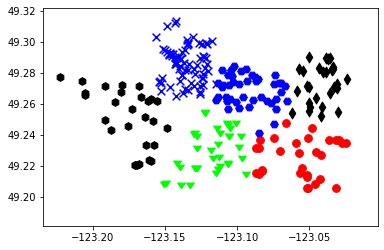

clustering results:
nodes in cluster #1
point(49.234947,-123.027254)
point(49.215521,-123.056107)
point(49.247450,-123.066226)
point(49.236946,-123.036380)
point(49.208211,-123.045695)
point(49.211296,-123.042283)
point(49.213935,-123.051533)
point(49.212392,-123.051395)
point(49.236498,-123.031411)
point(49.238138,-123.074290)
point(49.229195,-123.045343)
point(49.227059,-123.041882)
point(49.236424,-123.029107)
point(49.231523,-123.084772)
point(49.231341,-123.086922)
point(49.215339,-123.087200)
point(49.214828,-123.084599)
point(49.228277,-123.056920)
point(49.238173,-123.050828)
point(49.205755,-123.051817)
point(49.205739,-123.050981)
point(49.216811,-123.082434)
point(49.216947,-123.082635)
point(49.244294,-123.048373)
point(49.229608,-123.070191)
point(49.234752,-123.058912)
point(49.218755,-123.055044)
point(49.236527,-123.084037)
point(49.234702,-123.024717)
point(49.205331,-123.031131)
nodes in cluster #2
point(49.275858,-123.024141)
point(49.255191,-123.050071)
point(49.290

In [13]:
geo_locs = []
# Leitura do arquivo csv constendo a localização das fontes
f = open('drinkingFountains.csv', 'r')
reader = csv.reader(f, delimiter=",")
# Salvar a localização de cada fonte como um objeto Point(latit, longit)
for line in reader:
    loc_ = Point(float(line[0]), float(line[1]))  #tuples for location
    geo_locs.append(loc_)

# Comandos para debug
#print len(geo_locs)
#for p in geo_locs:
#    print "%f %f" % (p.latit, p.longit)

# Rodar o algoritmo k_means para realizar o clustering
cluster = clustering(geo_locs, 6)
flag = cluster.k_means(True)
if flag == -1:
    print ("Error in arguments!")
else:
    # Printar o resultado do clustering
    print ("clustering results:")
    cluster.print_clusters(cluster.clusters)